## Importing Library

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.applications import ResNet50 , VGG16
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, MaxPool2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import os
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns

In [2]:
from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadfathifarhat","key":"7db5203fc40607ba675837f473b53609"}'}

In [3]:
import os
import zipfile

# Buat direktori .kaggle dan pindahkan credential
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Unduh semua dataset yang dibutuhkan
!kaggle datasets download -d borhanitrash/animal-image-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/borhanitrash/animal-image-classification-dataset
License(s): MIT


In [5]:
# Ekstrak ke folder data/
!unzip -o animal-image-classification-dataset.zip -d ./data/

Archive:  animal-image-classification-dataset.zip
  inflating: ./data/Animals/cats/0_0001.jpg  
  inflating: ./data/Animals/cats/0_0002.jpg  
  inflating: ./data/Animals/cats/0_0003.jpg  
  inflating: ./data/Animals/cats/0_0004.jpg  
  inflating: ./data/Animals/cats/0_0005.jpg  
  inflating: ./data/Animals/cats/0_0006.jpg  
  inflating: ./data/Animals/cats/0_0007.jpg  
  inflating: ./data/Animals/cats/0_0008.jpg  
  inflating: ./data/Animals/cats/0_0009.jpg  
  inflating: ./data/Animals/cats/0_0010.jpg  
  inflating: ./data/Animals/cats/0_0011.jpg  
  inflating: ./data/Animals/cats/0_0012.jpg  
  inflating: ./data/Animals/cats/0_0013.jpg  
  inflating: ./data/Animals/cats/0_0014.jpg  
  inflating: ./data/Animals/cats/0_0015.jpg  
  inflating: ./data/Animals/cats/0_0016.jpg  
  inflating: ./data/Animals/cats/0_0017.jpg  
  inflating: ./data/Animals/cats/0_0018.jpg  
  inflating: ./data/Animals/cats/0_0019.jpg  
  inflating: ./data/Animals/cats/0_0020.jpg  
  inflating: ./data/Animals/ca

In [6]:
import os
print(os.listdir('./data/Animals'))

['cats', 'snakes', 'dogs']


## Splitting Data

In [7]:
import os
import pandas as pd

# Path ke dataset
base_dir = './data/Animals'

# Kelas target
target_classes = ['cats', 'dogs', 'snakes']

# Ekstensi file gambar yang valid
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')

# Membuat dataframe kosong
train_df = []

# Looping tiap kelas
for class_name in target_classes:
    class_path = os.path.join(base_dir, class_name)
    if os.path.exists(class_path):
        for img_name in os.listdir(class_path):
            full_path = os.path.join(class_path, img_name)
            if os.path.isfile(full_path) and img_name.lower().endswith(valid_extensions):
                train_df.append({'filename': full_path, 'class': class_name[:-1]})  # hilangkan 's' di akhir

# Buat dataframe dari list
train_df = pd.DataFrame(train_df)

# Cek jumlah data
print(f"Total training images: {len(train_df)}")
#print(train_df['class'].value_counts())
train_df.head()

Total training images: 3000


,filename,class
0,./data/Animals/cats/0_0786.jpg,cat
1,./data/Animals/cats/0_0488.jpg,cat
2,./data/Animals/cats/0_0084.jpg,cat
3,./data/Animals/cats/0_0700.jpg,cat
4,./data/Animals/cats/0_0910.jpg,cat


Membagi Train, Validation, dan Test Data ke Folder Terpisah

In [10]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

# Path target split
base_split_dir = './data/split'
train_dir = os.path.join(base_split_dir, 'train')
val_dir = os.path.join(base_split_dir, 'val')
test_dir = os.path.join(base_split_dir, 'test')

# Membuat folder target split
for split_dir in [train_dir, val_dir, test_dir]:
    os.makedirs(split_dir, exist_ok=True)

# Daftar class
classes = os.listdir(base_dir)

# Mulai split per kelas
for class_name in classes:
    class_path = os.path.join(base_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # Ambil semua gambar
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Shuffle
    random.shuffle(images)

    # Split train:val:test = 70:15:15
    train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    # Copy ke masing-masing folder
    for split_name, split_imgs in [('train', train_imgs), ('val', val_imgs), ('test', test_imgs)]:
        target_dir = os.path.join(base_split_dir, split_name, class_name)
        os.makedirs(target_dir, exist_ok=True)
        for img in split_imgs:
            src = os.path.join(class_path, img)
            dst = os.path.join(target_dir, img)
            shutil.copy2(src, dst)

print("✅ Splitting selesai.")

✅ Splitting selesai.


## Modelling

### Image Generator

In [11]:
# Parameter generator
img_height, img_width = 150, 150
batch_size = 32


train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

validation_generator = train_datagen.flow_from_directory(
    os.path.join(base_split_dir, 'val'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_split_dir, 'train'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = train_datagen.flow_from_directory(
    os.path.join(base_split_dir, 'test'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 90 images belonging to 3 classes.
Found 2100 images belonging to 3 classes.
Found 450 images belonging to 3 classes.


### CNN Architecture (with base model MobileNetV2)

In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Base model MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))
base_model.trainable = False  # freeze layer

model_mobilenet_seq = Sequential([
    base_model,
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 kelas: cats, dogs, snakes
])

model_mobilenet_seq.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Tampilkan arsitektur
model_mobilenet_seq.summary()

<ipython-input-12-7bb01f0082fc>:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 5, 5, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,631,267 (10.04 MB)

 Trainable params: 373,283 (1.42 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
# ==================== Class Weights Calculation ====================
train_cats = './data/Animals/cats'
train_dogs = './data/Animals/dogs'
train_snakes = './data/Animals/snakes'

count_cats = len(os.listdir(train_cats))
count_dogs = len(os.listdir(train_dogs))
count_snakes = len(os.listdir(train_snakes))

total_images = count_cats + count_dogs + count_snakes
weight_cats = (1 / count_cats) * (total_images / 3.0)
weight_dogs = (1 / count_dogs) * (total_images / 3.0)
weight_snakes = (1 / count_snakes) * (total_images / 3.0)

class_weights = {0: weight_cats, 1: weight_dogs, 2: weight_snakes}

# ==================== Callbacks ====================
earlystop = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
    verbose=1,
    min_delta=0.001
)

checkpoint = ModelCheckpoint(
    'best_model_mobilenet_seq.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# ==================== Training ====================
history_mobilenet_seq = model_mobilenet_seq.fit(
    train_generator,
    epochs=30,
    batch_size=32,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[earlystop, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 787ms/step - accuracy: 0.8175 - loss: 0.4903
Epoch 1: val_accuracy improved from -inf to 0.95556, saving model to best_model_mobilenet_seq.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 66s 907ms/step - accuracy: 0.8187 - loss: 0.4874 - val_accuracy: 0.9556 - val_loss: 0.2323
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.9534 - loss: 0.1242
Epoch 2: val_accuracy did not improve from 0.95556
66/66 ━━━━━━━━━━━━━━━━━━━━ 54s 822ms/step - accuracy: 0.9535 - loss: 0.1241 - val_accuracy: 0.9333 - val_loss: 0.1291
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 801ms/step - accuracy: 0.9608 - loss: 0.0891
Epoch 3: val_accuracy did not improve from 0.95556
66/66 ━━━━━━━━━━━━━━━━━━━━ 82s 830ms/step - accuracy: 0.9609 - loss: 0.0889 - val_accuracy: 0.9556 - val_loss: 0.1571
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - accuracy: 0.9622 - loss: 0.0986
Epoch 4: val_accuracy did not improve from 0.95556
66/66 ━━━━━━━━━━━━━━━━━━━━ 55s 837ms/step - accur

## Evaluate Model

In [14]:
from sklearn.metrics import classification_report, accuracy_score

# ============ 1. Evaluasi Akurasi pada Training Set ===========
train_loss, train_acc = model_mobilenet_seq.evaluate(train_generator, verbose=0)
print(f"Training Accuracy: {train_acc * 100:.2f}%")

# ============ 2. Evaluasi Akurasi pada Testing Set ============
test_loss, test_acc = model_mobilenet_seq.evaluate(test_generator, verbose=0)
print(f"Testing Accuracy (evaluate): {test_acc * 100:.2f}%")

Training Accuracy: 95.67%
Testing Accuracy (evaluate): 95.78%


15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 791ms/step

Classification Report:
              precision    recall  f1-score   support

        cats       0.98      0.93      0.95       150
        dogs       0.92      0.97      0.94       150
      snakes       0.99      0.99      0.99       150

    accuracy                           0.96       450
   macro avg       0.96      0.96      0.96       450
weighted avg       0.96      0.96      0.96       450



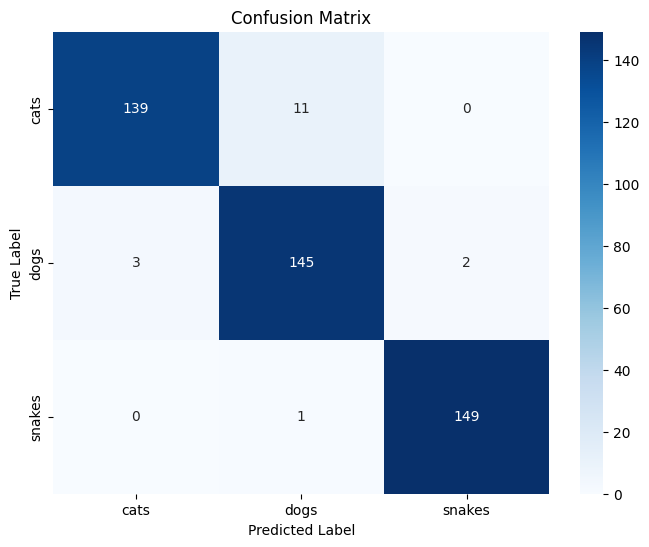

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns

# ==================== Classification Report ===================
y_pred_probs = model_mobilenet_seq.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# ====================== Confusion Matrix =======================
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

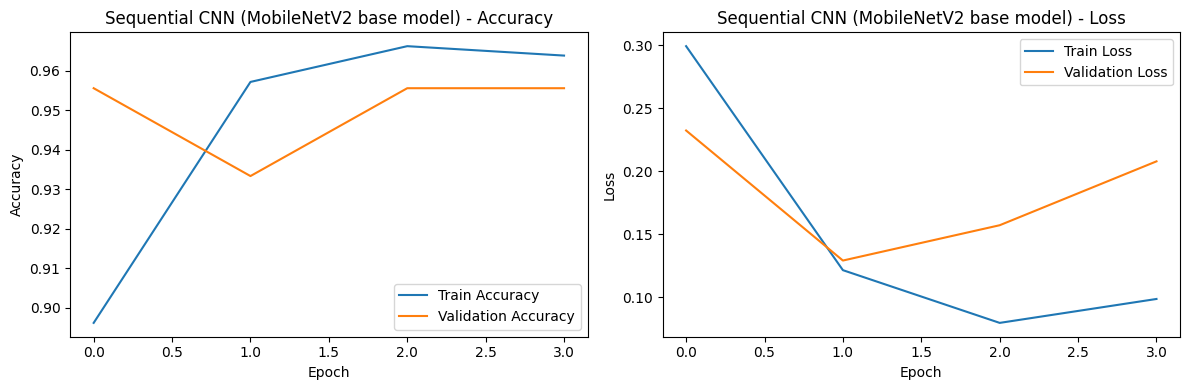

In [16]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    plt.figure(figsize=(12, 4))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Panggil fungsi untuk model_mobilenet_seq
plot_history(history_mobilenet_seq, "Sequential CNN (MobileNetV2 base model)")

## Save Model

In [17]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [18]:
import tensorflow as tf
import os
import tensorflowjs as tfjs

def save_model_all_formats(model, model_name):
    save_path = f'./saved_models/{model_name}'
    os.makedirs(save_path, exist_ok=True)

    # 1. SavedModel (untuk TFLite / TF Serving)
    export_path = os.path.join(save_path, "savedmodel")
    model.export(export_path)  # Ganti model.save() dengan export()

    # 2. TFLite
    converter = tf.lite.TFLiteConverter.from_saved_model(export_path)
    tflite_model = converter.convert()
    with open(f"{save_path}/{model_name}.tflite", "wb") as f:
        f.write(tflite_model)

    # 3. TensorFlow.js
    tfjs.converters.convert_tf_saved_model(export_path, f"{save_path}/tfjs")

    print(f"{model_name} saved successfully in all formats.")

# Contoh penyimpanan:
save_model_all_formats(model_mobilenet_seq, "CNN_MobileNetV2")

Saved artifact at './saved_models/CNN_MobileNetV2/savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  139505135282192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139505135282768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139505135286224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139505135285840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139505135284688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139505135286416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139505135285456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139505135282384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139505135286608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139505135284496: TensorSpec(shape=(), dtype=tf.resource